In [ ]:
# import pandas as pd
# import json
# import ast
# import numpy as np

# # Load the ROI data from the JSON file
# with open(r'roi_data\camera\front_room_roi.json', 'r') as f:
#     roi_data = json.load(f)

# # Extract all ROI polygons and calculate their bounding boxes
# roi_rectangles = {}
# for roi_name, points_dict in roi_data['roi'].items():
#     points = np.array(list(points_dict.values()))
#     min_x, min_y = np.min(points, axis=0)
#     max_x, max_y = np.max(points, axis=0)
#     roi_rectangles[roi_name] = {'min_x': min_x, 'min_y': min_y, 'max_x': max_x, 'max_y': max_y}

# # Load the detections log
# df_detections = pd.read_csv(r'detections_log_front_room_2.csv')

# # Convert the string representation of person_xy to a list of floats
# df_detections['person_xy'] = df_detections['person_xy'].apply(ast.literal_eval)

# # Function to check if a point is inside a given bounding box
# def is_point_in_roi(point_xy, rect_min_x, rect_min_y, rect_max_x, rect_max_y):
#     x, y = point_xy
#     return rect_min_x <= x <= rect_max_x and rect_min_y <= y <= rect_max_y

# # Prepare a dictionary to store total time for each ROI
# total_time_per_roi = {roi_name: 0.0 for roi_name in roi_rectangles.keys()}

# # Process the data frame, grouping by video_time_sec to handle frame by frame
# grouped_by_frame = df_detections.groupby('video_time_sec')

# previous_video_time_sec = None

# for video_time_sec, frame_data in grouped_by_frame:
    
#     # Calculate the duration of the current frame
#     frame_duration = 0
#     if previous_video_time_sec is not None:
#         frame_duration = video_time_sec - previous_video_time_sec
#     previous_video_time_sec = video_time_sec

#     # Find which ROIs have a person in the current frame
#     rois_with_person = set()
#     for _, person_data in frame_data.iterrows():
#         person_xy = person_data['person_xy']
#         # Check if the current person is in any ROI
#         for roi_name, rect_coords in roi_rectangles.items():
#             if is_point_in_roi(person_xy, rect_coords['min_x'], rect_coords['min_y'], rect_coords['max_x'], rect_coords['max_y']):
#                 rois_with_person.add(roi_name)
    
#     # Add the frame duration to the total time for each ROI that had a person
#     for roi_name in rois_with_person:
#         total_time_per_roi[roi_name] += frame_duration

# # Create the final roi_log DataFrame
# roi_log = pd.DataFrame(total_time_per_roi.items(), columns=['ROI Booth', 'Total Seconds'])

# print("Final roi_log table:")
# print(roi_log)

Final roi_log table:
  ROI Booth  Total Seconds
0   Booth_1        509.812
1   Booth_2        645.400


In [23]:
import pandas as pd
import json
import ast
import numpy as np

# Load the ROI data from the JSON file
# Corrected path to point to the file in the current directory
with open(r'roi_data\camera\front_room_roi.json', 'r') as f:
    roi_data = json.load(f)

# Extract all ROI polygons and calculate their bounding boxes
roi_rectangles = {}
for roi_name, points_dict in roi_data['roi'].items():
    points = np.array(list(points_dict.values()))
    min_x, min_y = np.min(points, axis=0)
    max_x, max_y = np.max(points, axis=0)
    roi_rectangles[roi_name] = {'min_x': min_x, 'min_y': min_y, 'max_x': max_x, 'max_y': max_y}

# Load the detections log
df_detections = pd.read_csv(r'detections_log_front_room_2.csv') # Corrected to the uploaded file name

# Convert the string representation of person_xy and person_box to a list of floats
df_detections['person_xy_parsed'] = df_detections['person_xy'].apply(ast.literal_eval)
df_detections['person_box_parsed'] = df_detections['person_box'].apply(ast.literal_eval)

# Create the new person_xy coordinate using the x from person_xy and y_max from person_box
df_detections['new_person_xy'] = df_detections.apply(
    lambda row: [row['person_xy_parsed'][0], row['person_box_parsed'][3]], axis=1)

# Function to check if a point is inside a given bounding box
def is_point_in_roi(point_xy, rect_min_x, rect_min_y, rect_max_x, rect_max_y):
    x, y = point_xy
    return rect_min_x <= x <= rect_max_x and rect_min_y <= y <= rect_max_y

# Prepare a dictionary to store total time for each ROI
total_time_per_roi = {roi_name: 0.0 for roi_name in roi_rectangles.keys()}

# Process the data frame, grouping by video_time_sec to handle frame by frame
grouped_by_frame = df_detections.groupby('video_time_sec')

previous_video_time_sec = None

for video_time_sec, frame_data in grouped_by_frame:
    
    # Calculate the duration of the current frame
    frame_duration = 0
    if previous_video_time_sec is not None:
        frame_duration = video_time_sec - previous_video_time_sec
    previous_video_time_sec = video_time_sec

    # Find which ROIs have a person in the current frame
    rois_with_person = set()
    for _, person_data in frame_data.iterrows():
        # Use the newly created 'new_person_xy' column for the check
        person_xy = person_data['new_person_xy']
        # Check if the current person is in any ROI
        for roi_name, rect_coords in roi_rectangles.items():
            if is_point_in_roi(person_xy, rect_coords['min_x'], rect_coords['min_y'], rect_coords['max_x'], rect_coords['max_y']):
                rois_with_person.add(roi_name)
    
    # Add the frame duration to the total time for each ROI that had a person
    for roi_name in rois_with_person:
        total_time_per_roi[roi_name] += frame_duration

# Create the final roi_log DataFrame
roi_log = pd.DataFrame(total_time_per_roi.items(), columns=['ROI Booth', 'Total Seconds'])

print("Final roi_log table:")
print(roi_log)

Final roi_log table:
  ROI Booth  Total Seconds
0   Booth_1        367.143
1   Booth_2        645.400


In [24]:
import pandas as pd

# Load the detections log
df_detections = pd.read_csv(r'detections_log_front_room_2.csv')

# Get the maximum video_time_sec, which represents the total duration of the log
max_video_time = df_detections['video_time_sec'].max()

# Convert the value to minutes for comparison
max_video_time_minutes = max_video_time / 60

print(f"Total video time according to the log: {max_video_time:.2f} seconds")
print(f"Total video time according to the log: {max_video_time_minutes:.2f} minutes")

Total video time according to the log: 645.40 seconds
Total video time according to the log: 10.76 minutes


C:\Users\ch0kism\AppData\Local\Temp\ipykernel_20928\2857154612.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ROI Booth', y='Total Seconds', data=roi_log, palette='viridis', width=0.2)


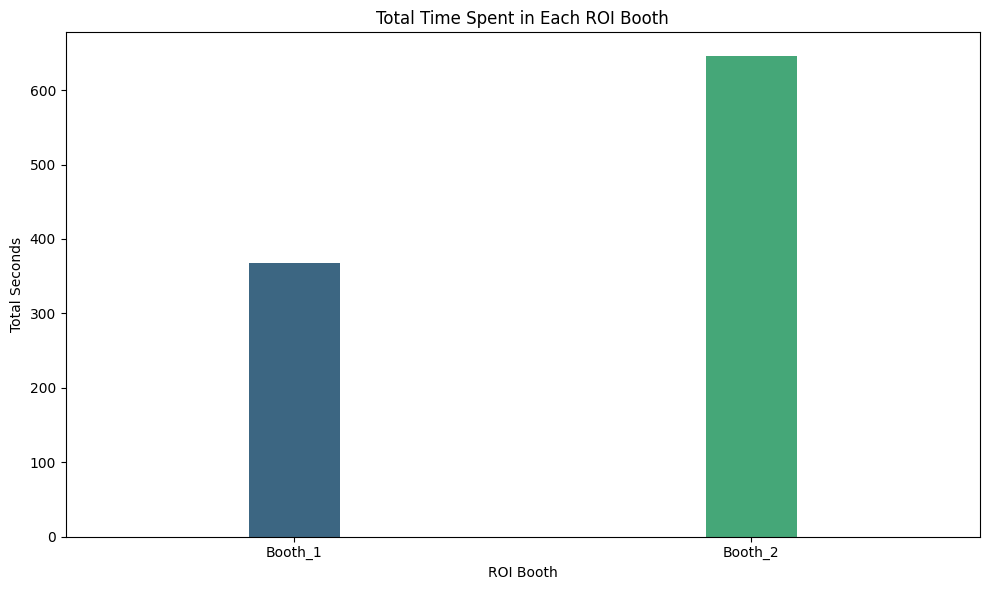

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='ROI Booth', y='Total Seconds', data=roi_log, palette='viridis', width=0.2)
plt.title('Total Time Spent in Each ROI Booth')
plt.xlabel('ROI Booth')
plt.ylabel('Total Seconds')
plt.xticks(rotation=0)
plt.tight_layout()

C:\Users\ch0kism\AppData\Local\Temp\ipykernel_20928\3049524182.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='ROI Booth', y='Total Seconds', data=roi_log, palette='viridis', width=0.2)


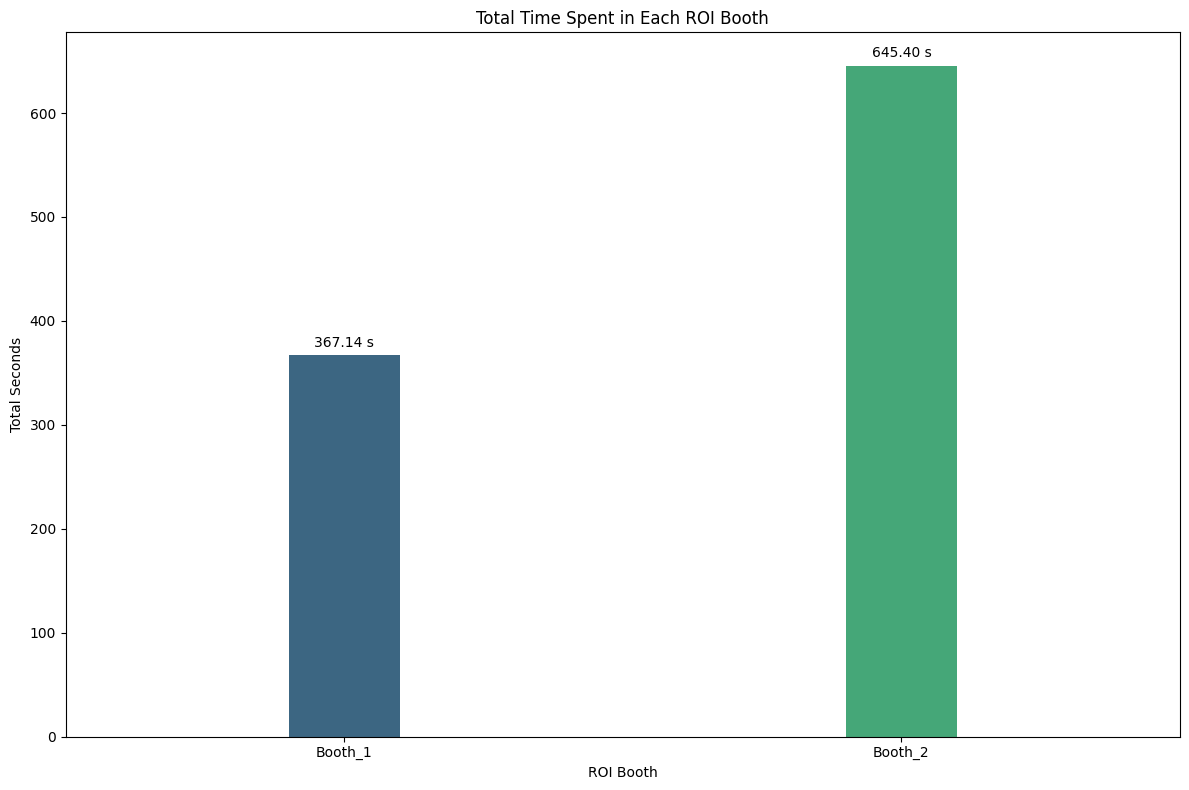

In [26]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='ROI Booth', y='Total Seconds', data=roi_log, palette='viridis', width=0.2)

plt.title('Total Time Spent in Each ROI Booth')
plt.xlabel('ROI Booth')
plt.ylabel('Total Seconds')
plt.xticks(rotation=0)
plt.tight_layout()

# Add the seconds value on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f} s', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

# plt.savefig('roi_booth_time_bar_plot.png')
plt.show()